# ROC AUC理解


这是一个对ROC AUC分数概念的一个理解笔记，这里参考的是[这篇笔记](http://www.cs.ru.nl/~tomh/onderwijs/dm/dm_files/roc_auc.pdf)

文章提到过[原始ROC论文](http://www.cs.ru.nl/~tomh/onderwijs/dm/dm_files/ROC101.pdf),和对模型比较的[一篇论文](http://www.cs.ru.nl/~tomh/onderwijs/dm/dm_files/salzberg97comparing.pdf)

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

## 数据

+ c1, 第一列是索引
+ c2, 第二列是真实标签
+ c3, 模型分类1的预测概率
+ c4, 模型分类2的预测概率

In [2]:
# !wget -c http://www.cs.ru.nl/~tomh/onderwijs/dm/dm_files/classprobabilities.csv
data = pd.read_csv('./classprobabilities.csv', header=None)
print(data.shape)
data.head()

(108, 4)


,0,1,2,3
0,1,1,0.88700,0.797060
1,2,0,0.13591,0.099401
2,3,0,0.55549,0.650750
3,4,0,0.23876,0.508570
4,5,0,0.14542,0.236290


### ROC curve

如何得出ROC曲线呢？首先先看看几个评价分类器好坏的标准。

<img src="tpr_fpr.png" alt="Drawing" style="width: 300px;height=20"/>

一个经典的ROC曲线如下图所示:

<img src="roc_examp.jpg" alt="Drawing" style="width: 300px;height=20"/>

ROC曲线计算的方式是如何呢？

ROC曲线是一个二维图像，它的x轴表示FP rate而y轴表示TP rate, 它能直观地表示分类器好坏的权衡(trade off)

我们观察两个点(0, 0)和(1, 1)，原点表示分类器预测的真实为1的样本数为0，同时假阳性的样本个数也为0，fpr = fp/n = 0, tpr = tp / p = 0,

如下图所示，则(0, 0)负样本都预测正确，而正样本都预测错误， 正负样本都为20

|  Name |  p1  |  p0  |
|  ---  | --- | --- | 
|  a1  |  0   |  0  |
|  a0  |  20   | 20  |

而(1, 1)则相反，所有正样本都预测正确，而负样本都预测错误

|  Name |  p1  |  p0  |
|  ---  | --- | --- | 
|  a1  |  20   |  20  |
|  a0  |  0   | 0  |


而(0, 1)则表示完美正确预测，(1, 0)表示完全错误预测。对角线点表示随机预测。


In [17]:
np.unique(data[1], return_counts=True)

(array([0, 1], dtype=int64), array([54, 54], dtype=int64))

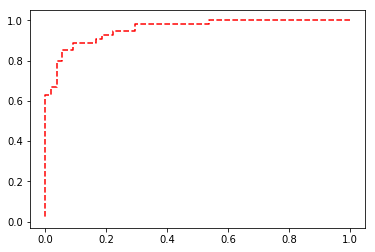

In [31]:
def cal_roc_curve(y_true, y_pred, threshold=0.5, plot=True):
    """原始算法, 当然还有更加有效的计算方式，这里就不再赘述了，可以附件pdf中进行实现"""
    
    
    sample_size = len(y_true)
    _, (neg_cnt, pos_cnt) = np.unique(data[1], return_counts=True)
    
    points = []
    for t in np.sort(y_pred):
        tp = fp = 0
        for i in range(sample_size):
        
            if y_pred[i] >= t:
                if y_true[i] == 1:
                    tp += 1
                else:
                    fp += 1
        points.append((fp / neg_cnt, tp / pos_cnt))
        
    points = np.array(points)
    if plot:
        x, y = points[:, 0], points[:, 1]
        plt.plot(x, y, 'r--')
    return points

points = cal_roc_curve(data[1], data[2])
# x, y = points[:, 0], points[:, 1]

# plt.plot(x, y, 'r--')

AUC分数是啥，area under the ROC curve,即ROC曲线下面的面积

由于随机预测是对角线，所以AUC必须大于0.5分类器才有作用。


In [34]:
# compute by hand.

def get_auc_score(y_true, y_pred):
    
    roc = cal_roc_curve(y_true, y_pred, plot=False)
    fpr, tpr = roc[:, 0], roc[:, 1]
    
    def trapezoid_area(x1, x2, y1, y2):
        """梯形面积"""
        base = abs(x1 - x2)
        height = (y1 + y2) / 2
        return base * height
    
    n = len(roc)       # for each curve roc points
    auc = 0
    for i in range(1, n):
        pre_x, pre_y = fpr[i-1], tpr[i-1]
        cur_x, cur_y = fpr[i], tpr[i]
        auc += trapezoid_area(pre_x, cur_x, pre_y, cur_y)
    return auc
    
get_auc_score(data[1].values, data[2].values), get_auc_score(data[1].values, data[3].values)

(0.9564471879286692, 0.7654320987654322)

In [6]:
# correct score from sklearn
roc_auc_score(data[1], data[2]), roc_auc_score(data[1], data[3])

(0.9564471879286695, 0.7654320987654321)

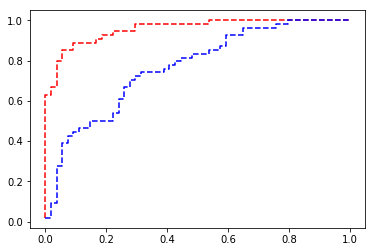

In [41]:
for i, c in [(2, 'r'), (3, 'b')]:
    fpr, tpr, _ = roc_curve(data[1], data[i])     # fpr, tpr, threshold
    plt.plot(fpr, tpr, '{}--'.format(c))